In [42]:
import requests
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import math

# Single Data Prediction

In [28]:
def preprocess_image(filename, image_size=(224, 224)):
    """
    Preprocess the image for model inference.
    
    Args:
        filename (str): Path to the image file.
        image_size (tuple): Target size for the image (height, width).
    
    Returns:
        list: Preprocessed image as a list for JSON payload.
    """
    # Read and decode the image
    image = tf.io.decode_image(open(filename, 'rb').read(), channels=3)
    
    # Resize the image to the target size
    image = tf.image.resize(image, image_size)
    
    # Add batch dimension and convert to list
    image_tensor = tf.expand_dims(image, 0).numpy().tolist()
    
    return image_tensor, image

In [29]:
def send_inference_request(image_tensor, endpoint):
    """
    Send a POST request for model inference.
    
    Args:
        image_tensor (list): Preprocessed image tensor.
        endpoint (str): URL of the model's prediction endpoint.
    
    Returns:
        dict: JSON response from the server.
    """
    # Prepare the JSON payload
    json_data = {
        "instances": image_tensor
    }
    
    # Send the POST request
    response = requests.post(endpoint, json=json_data)
    
    # Check if the request was successful
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Request failed with status code {response.status_code}: {response.text}")

In [30]:
def parse_prediction(response_data):
    """
    Parse the model's prediction from the JSON response.
    
    Args:
        response_data (dict): JSON response from the server.
    
    Returns:
        int: Predicted class index.
    """
    # Extract predictions from the response
    predictions = response_data['predictions']
    
    # Get the index of the highest probability class
    prediction = tf.argmax(predictions[0]).numpy()
    
    return prediction

In [31]:
def map_prediction_to_label(prediction):
    """
    Map the predicted class index to the corresponding label.
    
    Args:
        prediction (int): Predicted class index.
    
    Returns:
        str: Corresponding label for the predicted class.
    """
    map_labels = {
        0: "battery",
        1: "biological",
        2: "brown-glass",
        3: "cardboard",
        4: "clothes",
        5: "green-glass",
        6: "metal",
        7: "paper",
        8: "plastic",
        9: "shoes",
        10: "trash",
        11: "white-glass"
    }
    
    return map_labels.get(prediction, "Unknown")

In [32]:
def predict_image_class(filename, endpoint):
    """
    Perform the entire prediction process on an image.
    
    Args:
        filename (str): Path to the image file.
        endpoint (str): URL of the model's prediction endpoint.
    
    Returns:
        str: Predicted class label.
    """
    # Preprocess the image
    image_tensor, image = preprocess_image(filename)
    
    # Send the inference request and get the response
    response_data = send_inference_request(image_tensor, endpoint)
    
    # Parse the prediction from the response
    prediction = parse_prediction(response_data)
    
    # Map the prediction to the corresponding label
    label = map_prediction_to_label(prediction)
    
    # Display the image with the predicted label
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(f"Predicted Label: {label}")
    plt.axis('off')
    plt.show()
    
    return label

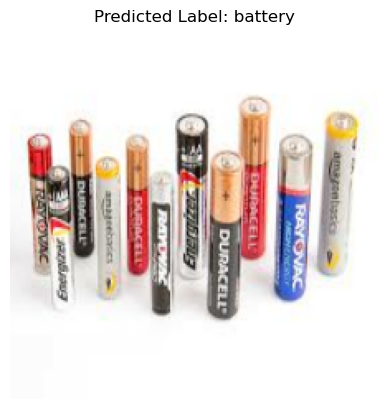

In [52]:
# Example usage
filename = 'Images Inference/battery235.jpg'
endpoint = "http://localhost:8502/v1/models/model:predict"

predicted_label = predict_image_class(filename, endpoint)

# Multiple Prediction in Folder

In [43]:
def preprocess_image(filename, image_size=(224, 224)):
    image = tf.io.decode_image(open(filename, 'rb').read(), channels=3)
    image = tf.image.resize(image, image_size)
    image_tensor = tf.expand_dims(image, 0).numpy().tolist()
    return image_tensor, image

In [44]:
def send_inference_request(image_tensor, endpoint):
    json_data = {"instances": image_tensor}
    response = requests.post(endpoint, json=json_data)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Request failed with status code {response.status_code}: {response.text}")

In [45]:
def parse_prediction(response_data):
    predictions = response_data['predictions']
    prediction = tf.argmax(predictions[0]).numpy()
    return prediction

In [46]:
def map_prediction_to_label(prediction):
    map_labels = {
        0: "battery",
        1: "biological",
        2: "brown-glass",
        3: "cardboard",
        4: "clothes",
        5: "green-glass",
        6: "metal",
        7: "paper",
        8: "plastic",
        9: "shoes",
        10: "trash",
        11: "white-glass"
    }
    return map_labels.get(prediction, "Unknown")

In [47]:
def predict_images_in_folder(folder_path, endpoint, cols=4):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    total_images = len(image_files)
    rows = math.ceil(total_images / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()

    for idx, filename in enumerate(image_files):
        full_path = os.path.join(folder_path, filename)
        image_tensor, image = preprocess_image(full_path)
        response_data = send_inference_request(image_tensor, endpoint)
        prediction = parse_prediction(response_data)
        label = map_prediction_to_label(prediction)

        # Display the image with the predicted label
        axes[idx].imshow(image.numpy().astype("uint8"))
        axes[idx].set_title(f"{filename}\n{label}")
        axes[idx].axis('off')

    # Hide any unused subplots
    for i in range(total_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

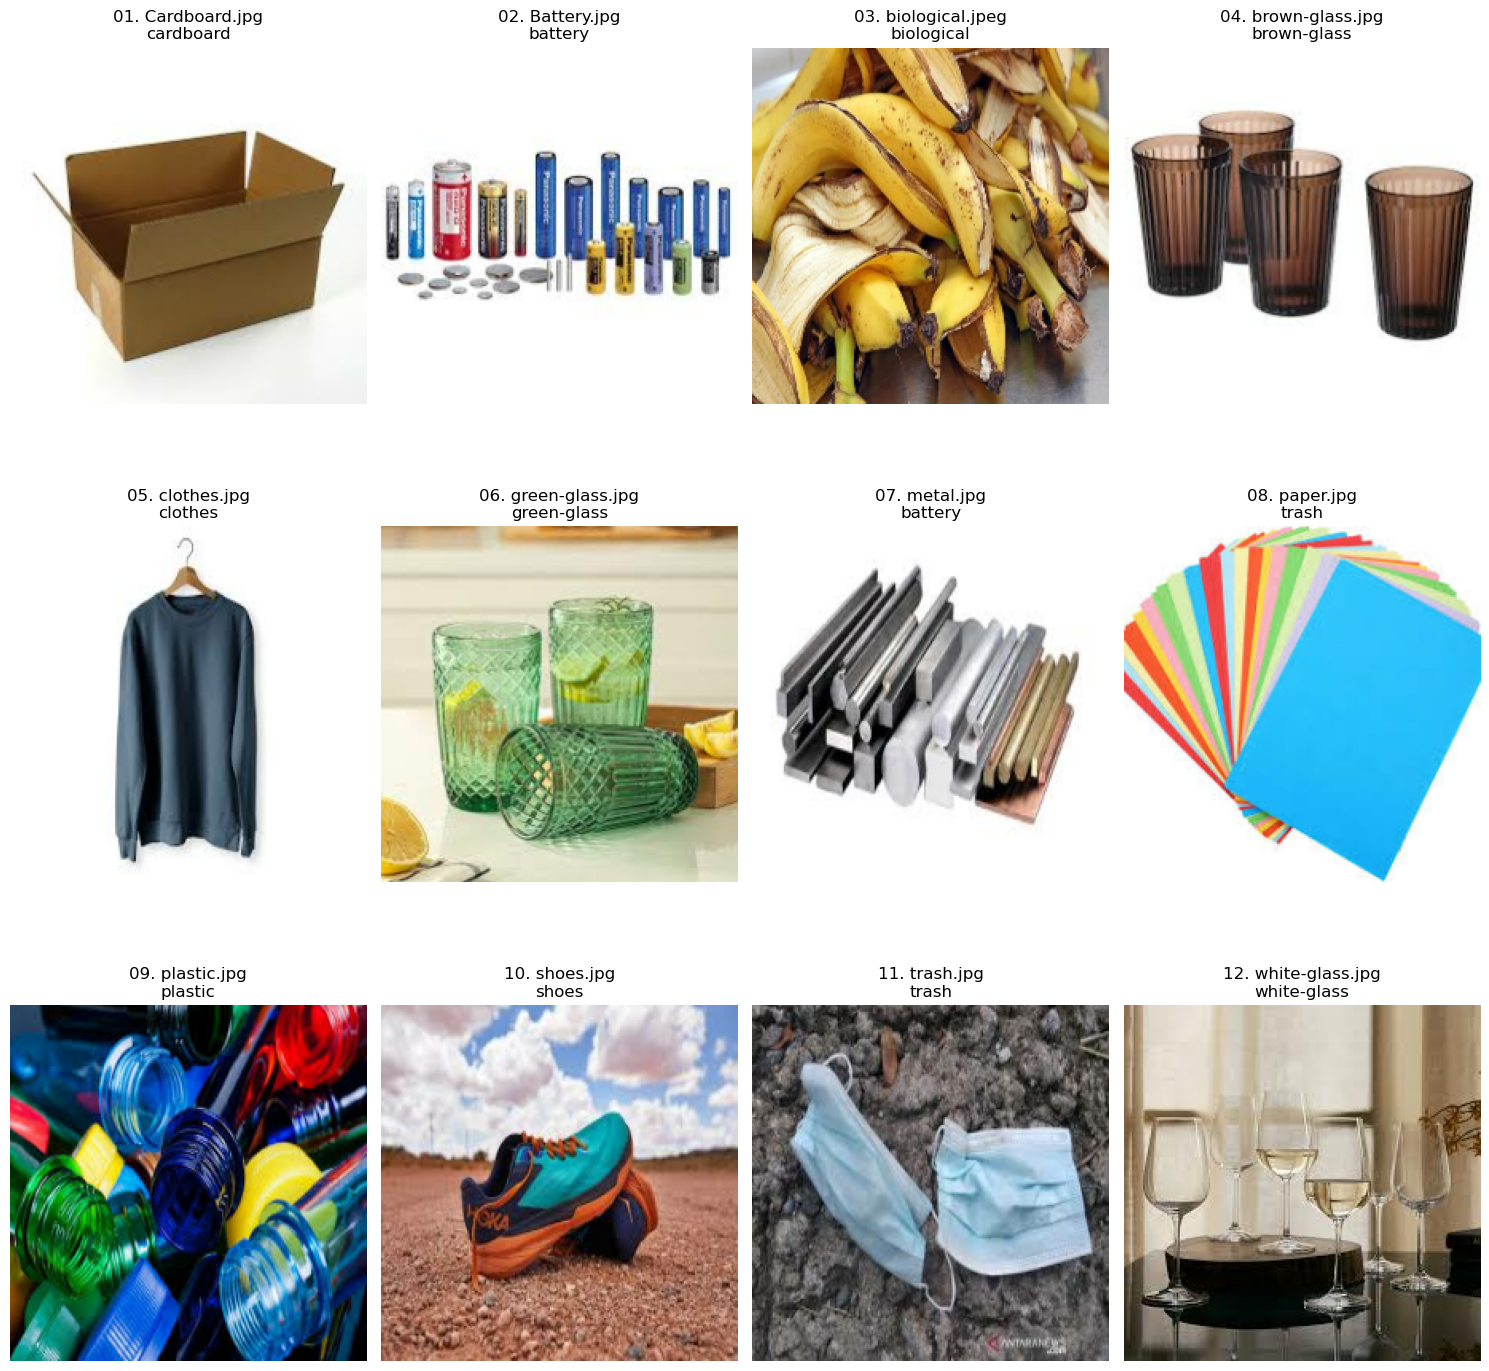

In [49]:
# Example usage
folder_path = 'Unseen Data/'
endpoint = "http://localhost:8502/v1/models/model:predict"
predict_images_in_folder(folder_path, endpoint, cols=4)